# Linear Models using PyMC

___

## Set up

In [1]:
# Import Packages
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from scipy import stats

# Set Seed
np.random.seed(42)

## Simulate Data

Let's continue with the cat knocking over a mug from the previous tutorial, but now we are going to make the outcome as a function of some independant variables that cause it to knock it over more or less.

For instance, my cat can't knock over my mug if I don't brew any coffee, and I'm not very regular with my brewing habits because I drink decaff, which allows me to be more random. 

In [2]:
brewed_coffee = stats.poisson(mu=4).rvs(14)

brewed_coffee

array([5, 4, 4, 4, 2, 5, 2, 5, 3, 5, 7, 1, 4, 3])

Let's say for each coffee that I brewed, the cat has a 75% probability to knock a mug over.

In [3]:
cat_knocks = stats.binom(n=brewed_coffee, p=0.75).rvs()

cat_knocks

array([5, 1, 2, 4, 2, 3, 1, 3, 2, 5, 6, 1, 2, 2])

Note how I use a binomial distribution, the sum of independent Bernoulli trials. This is because each time I brew a coffee, there's a 75% probability that my cat will knock it over. 

We can see that now the number of cat knocks is a function of the number of cups that I brew. Let's visualise the pattern quickly. 

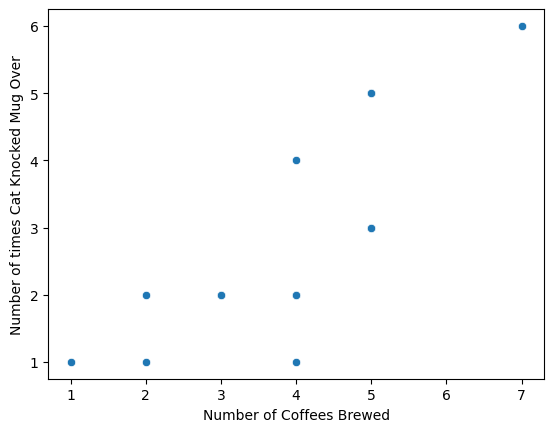

In [4]:
df = pd.DataFrame(dict(brewed_coffee=brewed_coffee,
                       cat_knocks=cat_knocks))

sns.scatterplot(x="brewed_coffee", y="cat_knocks", data=df)
plt.xlabel("Number of Coffees Brewed")
plt.ylabel("Number of times Cat Knocked Mug Over")
plt.show()

We can see now that the connection between the number of coffees brewed isn't deterministic, but it does have a pattern. Let's try and use a linear model to recover the rate at which the cat knocks the mug over.

## Building the model

The difference to the previous example is that now will have a likelihood function which is itself a function of the inputs to our model rather than being comprised entirely of parameters.

$$
\begin{align}
K &\sim \textrm{N}(\mu, \sigma) \\
\mu &= \beta_0 + \beta_c C \\
\beta_0 &\sim \textrm{N}(0, 0.5)\\
\beta_1 &\sim \textrm{N}(0.5, 0.5)\\
\sigma &\sim \textrm{exp}(1)
\end{align}
$$

The number of times our cat knocks the mug over (K) is normally distributed around some mean (μ) and a standard deviation (σ), similar to our previous model.

What changes is that the mean is now a deterministic combination of the parameters and our data instead of being a parameter. If we know the parameters with certainty, then we know μ. 

The mean can be broken down into an intercept/baseline (b0) and the rate at which the outcome increases given the number of coffees (b1). Note that each of these unknown parameters gets its own distribution. Meanwhile, our data are known as C.

Note that here I know that if we brew no coffee, our cat can't knock it over. Therefore, I set the priors for b0 to be tight around 0. I expect the rate to be between 0 and 1 because our cat can't knock over the mug more often than I brew coffee, but let's keep it simple and say that it's a number that we're reasonably confident is close to `0.5`.

Once again, our only expectation is that sigma is greater than 0. I used an exponential distribution instead of a half-normal, which puts more prior probability closer to 0 and allows a long tail of events. 

Why is it still okay to use a *Normal* likelihood? It's because we expect the distribution of the number of cups my cat knocks my mug over, conditional on the number of coffees I brew, to be explained using a *Normal* distribution. It's also possible to use a general linear model (GLM) to explain it using a *Poisson* distribution instead, but we're keeping it simple. 

In [5]:
with pm.Model() as cat_model:
    σ = pm.Exponential("σ", lam=1)

    β0 = pm.Normal("β0", mu=0, sigma=0.5)
    β1 = pm.Normal("β1", mu=0.5, sigma=0.5)
    
    μ = β0 + β1 * df["brewed_coffee"]

    likelihood = pm.Normal("likelihood", mu=μ, sigma=σ, observed=df["cat_knocks"])

This is already quite powerful, you can basically now do all of the usual frequentist linear model tricks from here such as using indicators, interactions and so on. All of that experience is now available for you to use in a Bayesian framework. 

Let's also have a little fun. We know that b1 must be between 0 and 1, so let's change the *Normal* prior to a *Beta* prior. 

The beta distribution spans between 0 and 1 and is a conjugate prior that you hear about if you learn Bayesian statstics the traditional way. That is, it's a special distribution whose parameters can be made functions of the data such that we can calculate our posterior distribution from our data correctly. 

For example, a `beta(alpha=1, beta=1)` distribution has a uniform distribution between 0 and 1, where each parameter can be considered as the number of successes and failed trials respectively. For instance, if you flip a coin and find that it's heads then you increment alpha by one and if it's tails you increment beta by 1.

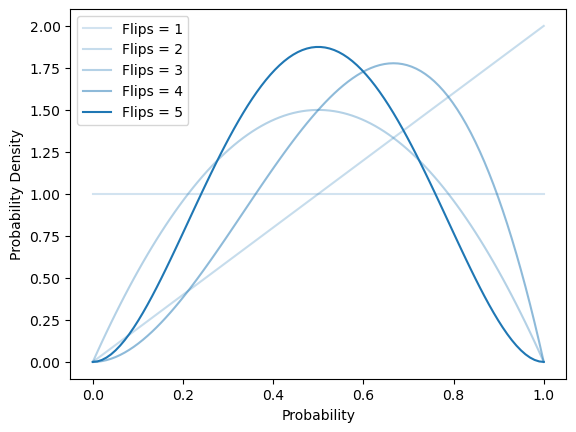

In [6]:
x = np.linspace(0, 1, 100)

plt.plot(x, stats.beta(1, 1).pdf(x=x), color=sns.color_palette()[0], alpha=1/5, label="Flips = 1")
plt.plot(x, stats.beta(2, 1).pdf(x=x), color=sns.color_palette()[0], alpha=1/4, label="Flips = 2")
plt.plot(x, stats.beta(2, 2).pdf(x=x), color=sns.color_palette()[0], alpha=1/3, label="Flips = 3")
plt.plot(x, stats.beta(3, 2).pdf(x=x), color=sns.color_palette()[0], alpha=1/2, label="Flips = 4")
plt.plot(x, stats.beta(3, 3).pdf(x=x), color=sns.color_palette()[0], alpha=1/1, label="Flips = 5")
plt.legend()
plt.xlabel("Probability")
plt.ylabel("Probability Density")
plt.show()


Above we can see how I increment each parameter by 1, as if we had the data `HTHTH`, leading to increased confidence of being close to 0.5 with each flip.

In [7]:
with pm.Model() as cat_model2:
    σ = pm.Exponential("σ", lam=1)

    β0 = pm.Normal("β0", mu=0, sigma=0.5)
    β1 = pm.Beta("β1", alpha=1, beta=1)
    
    μ = β0 + β1 * df["brewed_coffee"]

    likelihood = pm.Normal("likelihood", mu=μ, sigma=σ, observed=df["cat_knocks"])

The new model here is as follows...

$$
\begin{align}
K &\sim \textrm{N}(\mu, \sigma) \\
\mu &= \beta_0 + \beta_c C \\
\beta_0 &\sim \textrm{N}(0, 0.5)\\
\beta_1 &\sim\textcolor{red}{\textrm{Beta}(1, 1)} \\
\sigma &\sim \textrm{exp}(1)
\end{align}
$$

The only difference is with b1, which I've now constrained to have uniform probability between 0 and 1.

## Prior Predictive Check

Now that we've built the model, let's have a look at what it produces. Once again, we follow our Bayesian workflow by seeing what data our model generate and whether it makes sense given our expectations.

In [8]:
with cat_model:
        prior_pred = pm.sample_prior_predictive(samples=4000)

with cat_model2:
        prior_pred2 = pm.sample_prior_predictive(samples=4000)

Sampling: [likelihood, β0, β1, σ]
Sampling: [likelihood, β0, β1, σ]


Note that once again, our parameters are not a function of our data, so we'll just take one chain and investigate it. 

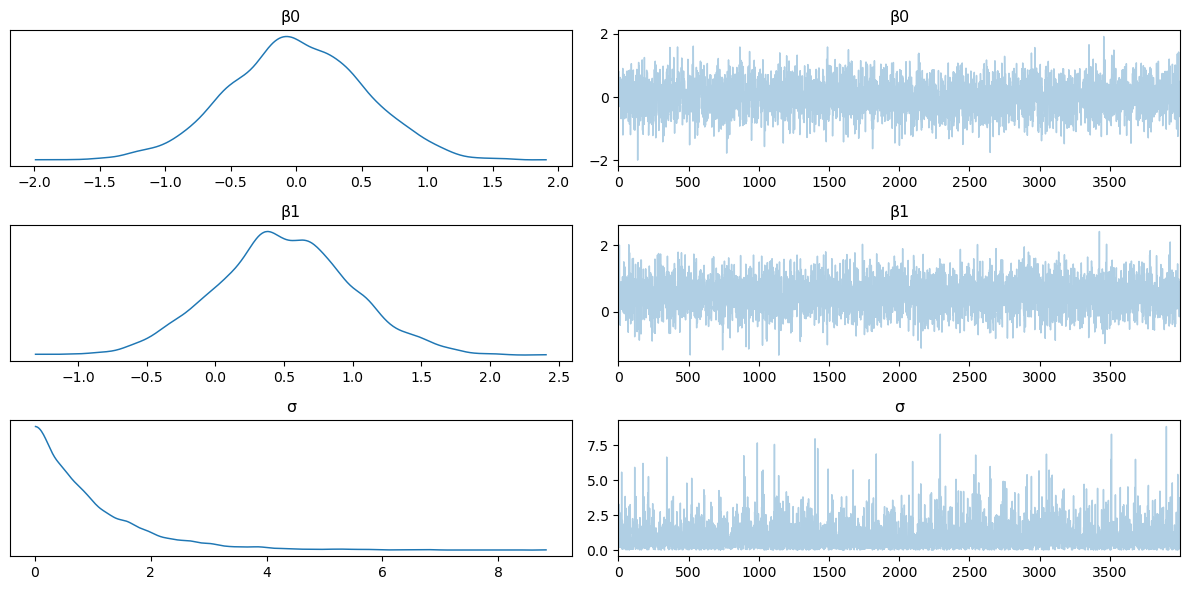

In [9]:
az.plot_trace(prior_pred.prior)
plt.tight_layout()
plt.show()

We can see how our priors are basically just the distributions as they were written...

When looking at the distribution for b1, since we know that probabilities above or below 0 or 1 are impossible, we could consider a tighter prior, but let's look at the prior predictive simulation before jumping to any conclusions.

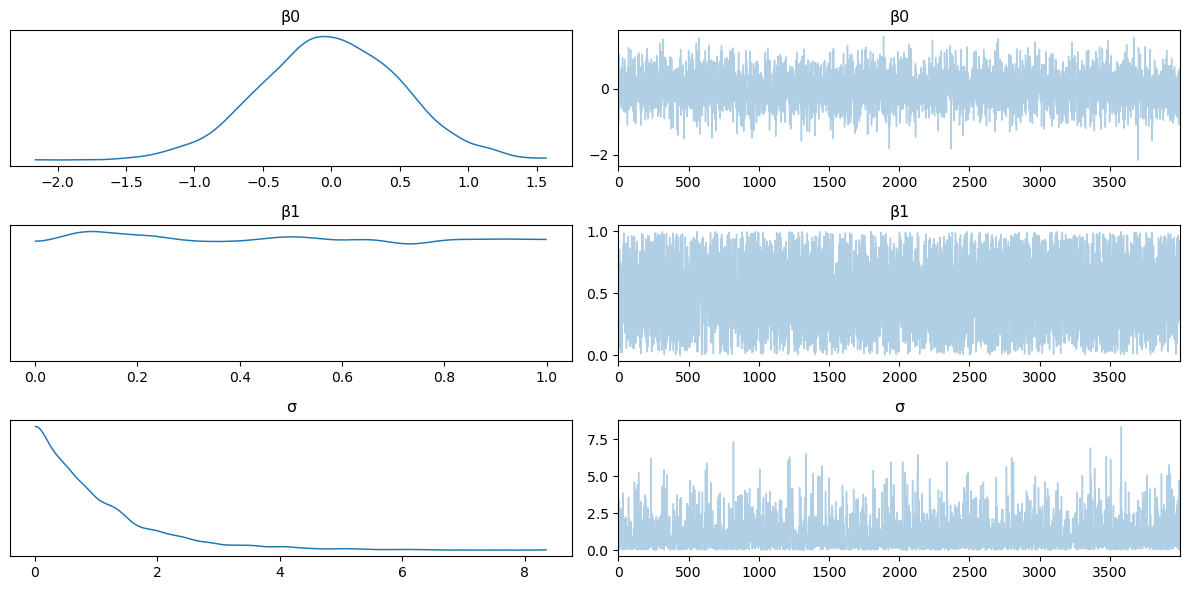

In [10]:
az.plot_trace(prior_pred2.prior)
plt.tight_layout()
plt.show()

Once again, the only differece between the two models is the prior that we used for b1, which is now a flat prior and will not allow probabilities above 1 or below 0. 

Let's take a look at what kind of data this generates. I'll write a function so that we can apply it to both models instead of duplicating a lot of code.

In [11]:
def plot_prior(trace, n_sims=50, alpha=1/5):

    C = np.linspace(0, 10, 10)
    K = trace.β0.values[0, :n_sims] + np.outer(C, trace.β1.values[0, :n_sims])

    for i in range(n_sims):
        plt.plot(C, K[:, i], alpha=alpha, color=sns.color_palette()[0])
    plt.xlabel("Number of Coffees Brewed")
    plt.ylabel("Number of times Cat Knocked Mug Over")
    plt.show()

    return

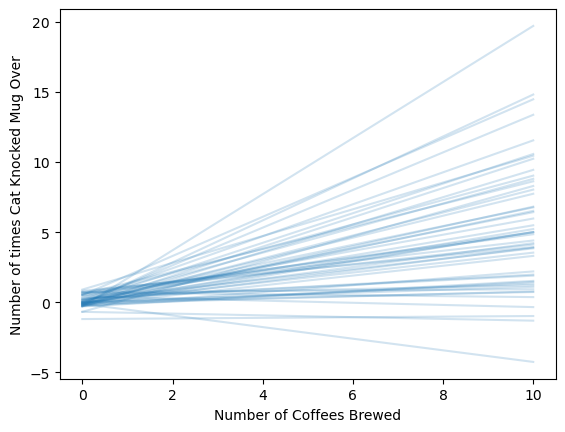

In [12]:
plot_prior(prior_pred.prior)

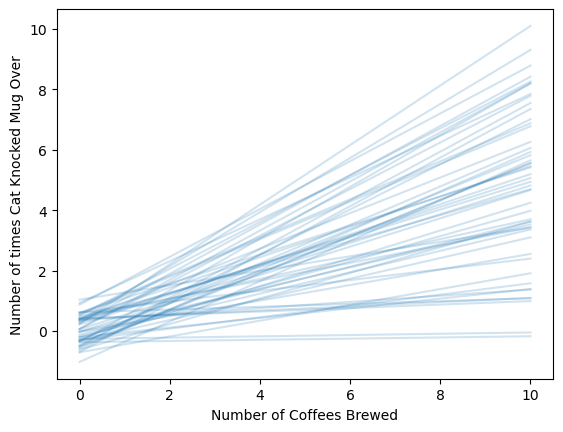

In [13]:
plot_prior(prior_pred2.prior)

Above we can see the prior predicted distribution for our models `cat_model` and `cat_model2` respectively. We can see that having a Beta distribution for b1 removes the impossible negative slope which will result my cat knocking over my mug negative times. 

We can also see that the intercept is tightly clustered around 0. However, this is a mistake because we know from the logic of our problem that it has to be 0. This leads to problems with our modelling later. 

It's important to get this right becase once we fit our model to the data we should not make changes to our models in order to prevent overfitting to our data. Taking the time to make sure that the prior predicted data fits our expectations given our understanding of the problem is essential. 

Note how even with relatively basic knowledge, we're already building models that are created to fit our specific use-case. This can lead to more precise esimates.

## Fitting the Model to Data

Now that we have the models, let's fit them to data!

In [14]:
with cat_model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β0, β1]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


In [15]:
with cat_model2:
    trace2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β0, β1]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


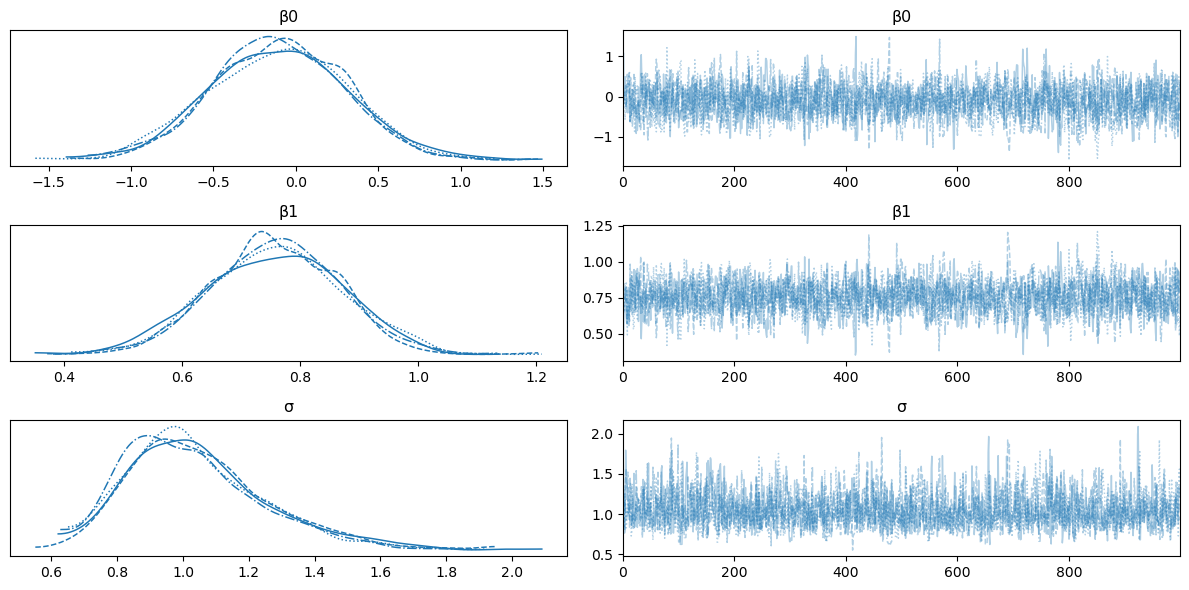

In [16]:
az.plot_trace(trace)
plt.tight_layout()
plt.show()

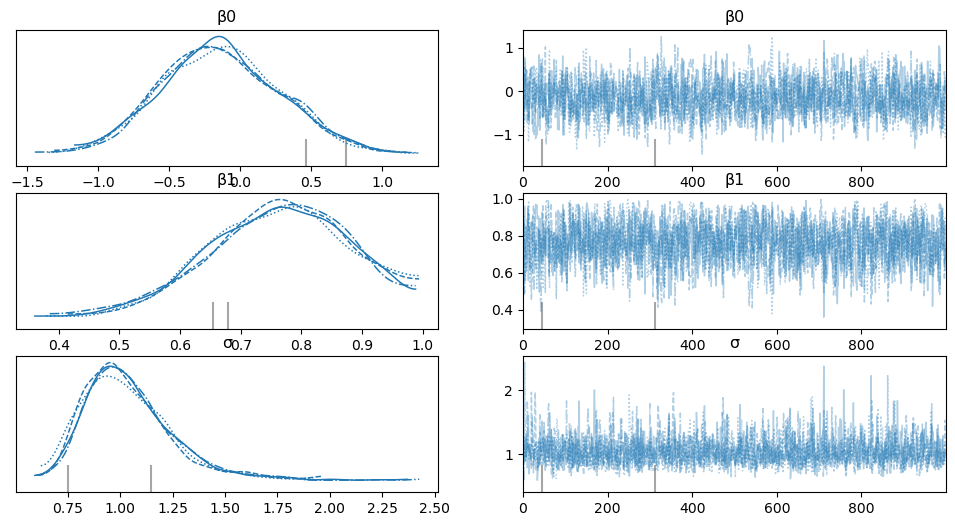

In [17]:
az.plot_trace(trace2)
plt.tight_layout
plt.show()

In [18]:
df_summary_1 = az.summary(trace, round_to=2)[["mean", "sd", "ess_bulk", "r_hat"]]
df_summary_2 = az.summary(trace2, round_to=2)[["mean", "sd", "ess_bulk", "r_hat"]]

pd.concat([df_summary_1, df_summary_2])\
    .assign(model=(["cat_model" for i in range(3)] + ["cat_model2" for i in range(3)]))\
    [["model", "mean", "sd", "ess_bulk", "r_hat"]]

,model,mean,sd,ess_bulk,r_hat
β0,cat_model,-0.10,0.41,1801.52,1.0
β1,cat_model,0.76,0.11,1767.93,1.0
σ,cat_model,1.04,0.21,1893.64,1.0
β0,cat_model2,-0.14,0.41,1411.86,1.0
β1,cat_model2,0.76,0.11,1318.02,1.0
σ,cat_model2,1.04,0.21,2023.22,1.0


Interestingly, it seems that `cat_model2` is not necessarily the best model. The model appears to have sampled well from the trace plots, but the effective sample size is lower than in the more naive model `cat_model`. 

In [19]:
def plot_posterior(trace, n_sims=50, alpha=1/5):

    C = np.linspace(0, 10, 10)
    K = trace.β0.values.reshape(-1) + np.outer(C, trace.β1.values)
    Ksim = K + np.random.normal(loc=0, scale=trace.σ.values.reshape(-1), size=K.shape)

    Kq = np.quantile(K, [(1-0.89)/2, 1 - ((1-0.89)/2)], axis=1)
    Ksimq = np.quantile(Ksim, [(1-0.89)/2, 1 - ((1-0.89)/2)], axis=1)
    
    plt.fill_between(C, Kq[0, :], Kq[1, :], alpha=0.6, color=sns.color_palette()[0], label="mean (89% CI)")
    plt.fill_between(C, Ksimq[0, :], Ksimq[1, :], alpha=0.2, color=sns.color_palette()[0], label="simulated (89% CI)")

    plt.axhline(0, color="black")
    
    sns.scatterplot(x="brewed_coffee", y="cat_knocks", data=df, color=sns.color_palette()[1])
    
    return

I use a function for plotting because it saves on code and it makes updating the plots a lot easier. 

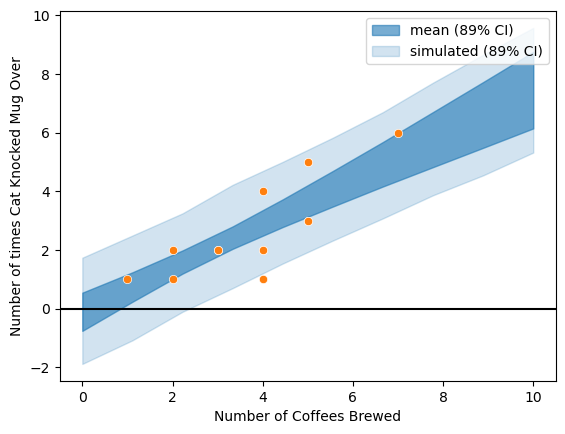

In [20]:
plot_posterior(trace.posterior, n_sims=50, alpha=1/5)
plt.xlabel("Number of Coffees Brewed")
plt.ylabel("Number of times Cat Knocked Mug Over")
plt.show()

The plot above shows the observed data alongside the model's posterior distributions for both the mean and the simulated data. While the model assumes a Normal likelihood, the underlying data-generating process is Binomial — my cat knocks over each coffee mug with a 75% chance.

Despite this mismatch, the model performs reasonably well. With only 14 days of data, the estimates for the intercept and slope are pulled slightly away from their true values. If I simulate with 4000 days, the posterior converges to the expected parameters (intercept ≈ 0, slope ≈ 0.75).

This illustrates a key Bayesian principle: a well-specified prior and model can still provide functional inference with limited data, but accuracy improves significantly as more evidence accumulates. A better-specified model — for example, using a Binomial likelihood — could achieve similar accuracy with fewer observations.

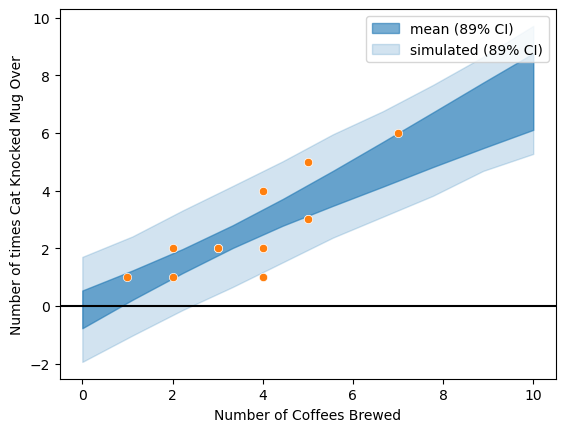

In [21]:
plot_posterior(trace2.posterior, n_sims=50, alpha=1/5)
plt.xlabel("Number of Coffees Brewed")
plt.ylabel("Number of times Cat Knocked Mug Over")
plt.show()

It seems that the two models perform similarly in the posterior predictive check. Typically, we would score the models to choose between them, especially if plotting them isn't as straightforward as in this case. 

Although we know that the priors for `cat_model2` are more realistic, we can see how we can get reasonable posterior estimates even if the model isn't entirely correct. This is important because we often don't know the real model in the real world. But by using simulated data, we can be confident that our models should work, at least in theory, and often, that's good enough. 

Let's use a forest plot to compare the parameters side by side. 

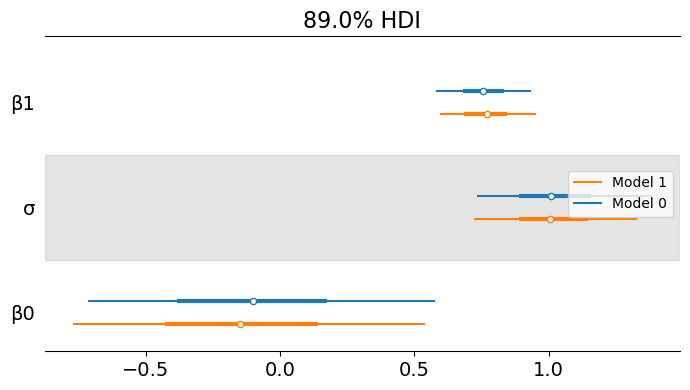

In [22]:
az.plot_forest([trace, trace2], hdi_prob=0.89, combined=True, figsize=(7, 4))
plt.tight_layout()
plt.show()

From both the forest plot and the posterior predictive check, we can see that the models are the same. But it's better to use the first model for inference because it has a higher effective sample size due to the model running more smoothly. 

## Using parameters for inference

Now that we have our posterior distribution

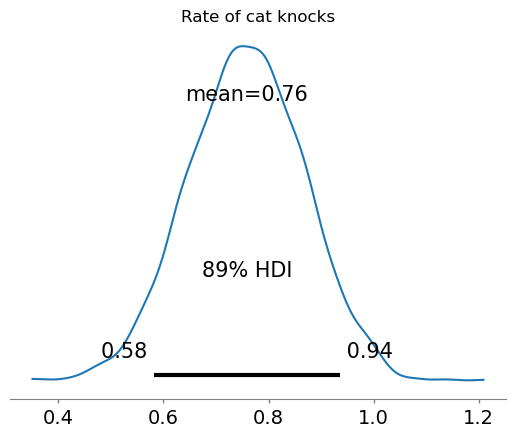

In [23]:
β_est = trace.posterior.β1.values.reshape(-1)

az.plot_posterior(β_est, hdi_prob=0.89)
plt.title("Rate of cat knocks")
plt.show()

In the plot above, the posterior distribution for the total probability that my cat knocks over a mug using `cat_model` (the sum of b0 and b1) occasionally exceeds 1, which isn't meaningful for a probability.

This is a  reflection of how modelling works. We did not place a constraint in the model that the output must be a valid probability. Meanwhile, the model was uncertain, especially with limited data, so it explored all regions consistent with the prior and likelihood, even if some combinations produced values above 1.

It's not meaningful to ask if the model is "wrong", all models are abstractions of reality, it just doesn't know enough to rule out those values and so this the best estimate it can come up with.

We **shouldn't** go back and "fix" the model just because we don't like the results. Retroactively narrowing priors or hard-coding constraints based on posterior behaviour leads to overfitting and can make us overly confident in our estimates. A better approach is acknowledging the misspecification and suggesting a more realistic model for future use.

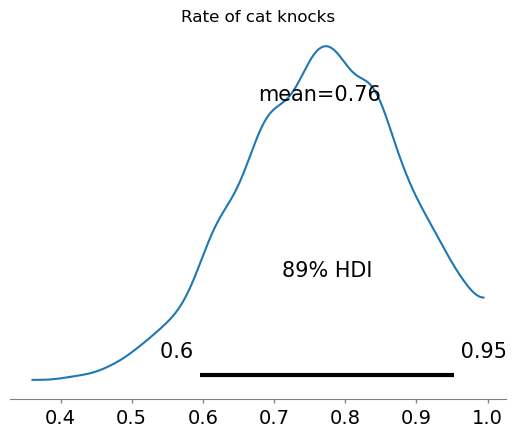

In [24]:
β_est = trace2.posterior.β1.values.reshape(-1)

az.plot_posterior(β_est, hdi_prob=0.89)
plt.title("Rate of cat knocks")
plt.show()

Meanwhile, `cat_model2` does a better job of estimating b1 even if we saw that the effective sample size is lower. Here, we're trading off accuracy (distance from the real value), precision (spread of the data) and the model reliability (stability of our model estimates). We know that the effective sample size of cat_model2 is lower, but it will at least give us estimates that make sense. 

I'll choose it for our estimate and conclude that our cat knocks over our mug with a probability of 76% with a 89% credible interval between 59% and 93%. We can say with a 99% probability that our cat knocks over our mug more than 50% of the time, but still doesn't always do it.

In [25]:
(β_est > 0.5).mean()

0.987